In [1]:
# Load packages
using Parameters
using QuantEcon
using Plots
using Format
using Interpolations
using Optim

## Problem 1

Part a

In [2]:
# Define the utility function
function u(c, l, p)
    @unpack β, σ, ν, ϕ = p
    return (c^(1-σ))/(1 - σ) - ϕ * (l^(1+1/ν)/(1 + 1/ν))
end

function update_bellman!(p, V, policy, kgrid, V0)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n)  
    
    vmax = -Inf
    max_idx = 0
    
    for i in 1:n
        k = kgrid[i]

        ki′ = 0
        li′ = 0
        ci′ = 0
        
        for j in 1:n
            k′ = kgrid[j]
            for b in 1:n  
                l = l_values[b]
                c′ = A * k^α * l^(1-α) + (1-δ) * k - k′
                if c′ >= 0
                    v = u(c′, l, p) + β * V0[j]
                    if v >= vmax
                        vmax = v
                        ki′ = kgrid[j]
                        li′ = l_values[b]
                        ci′ = c′
                    end
                end
            end
        end

        V[i] = vmax 
        policy[i] = (ki′, li′, ci′)  
    end
end

# Implement the VFI algorithm
function solve_vfi(p, kgrid; tol = 1e-6, max_iter = 1000)
    V0 = zeros(length(kgrid))
    V = similar(V0)
    policy = Array{Tuple{Float64, Float64, Float64}, 1}(undef, length(kgrid))
    max_idxs = []  # Array to store the index of vmax
    
    for iter in 1:max_iter
        update_bellman!(p, V, policy, kgrid, V0)
        error = maximum(abs.(V .- V0))
        if error < tol
            println("Converged after $iter iterations.")
            return V, policy
        end
        copy!(V0, V)
    end
    
    error("Did not converge after $max_iter iterations.")
end

# Parameters
p = (
    β = 0.95,    # Discount Rate
    δ = 0.05,    # Depreciation of capital
    σ = 2.0,     # Uncertainty aversion
    ν = 2.0,     # Risk aversion
    α = 1/3,     # Returns to scale
    A = 1.0,     # Productivity
    ϕ = 1.0     # Disutility from labor

)



(β = 0.95, δ = 0.05, σ = 2.0, ν = 2.0, α = 0.3333333333333333, A = 1.0, ϕ = 1.0)

Converged after 331 iterations.
Converged after 331 iterations.
Converged after 331 iterations.
Converged after 331 iterations.
Converged after 331 iterations.


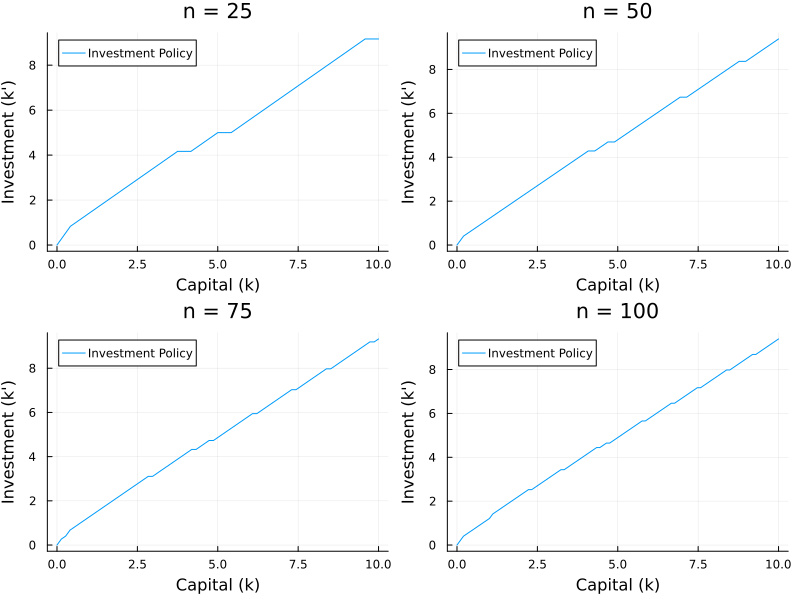

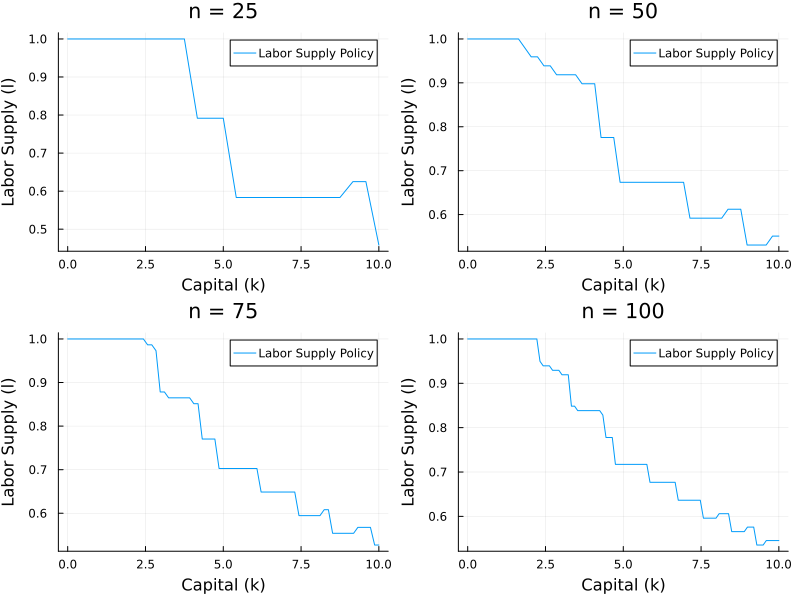

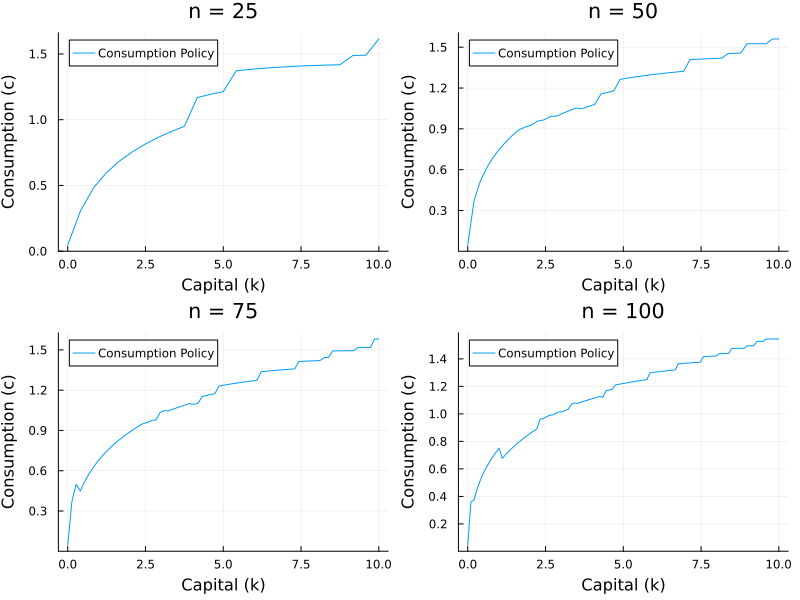

In [3]:
n_values = [25, 50, 75, 100]
plot_titles = ["n = 25", "n = 50", "n = 75", "n = 100"]
plots_investment = []
plots_labour = []
plots_consumption = []

for (i, n) in enumerate(n_values)
    # Define the grid for capital
    kgrid = LinRange(1e-4, 10, n)
    
    # Solve the model
    V, policy = solve_vfi(p, kgrid)
    
    # Extract policy functions
    ki_policy = [p[1] for p in policy]
    li_policy = [p[2] for p in policy]
    ci_policy = [p[3] for p in policy]

    # Plot policy functions with markers at maxima
    p1 = plot(kgrid, ki_policy, xlabel="Capital (k)", ylabel="Investment (k')", label="Investment Policy", title=plot_titles[i])
    push!(plots_investment, p1)
    
    p2 = plot(kgrid, li_policy, xlabel="Capital (k)", ylabel="Labor Supply (l)", label="Labor Supply Policy", title=plot_titles[i])
    push!(plots_labour, p2)
    
    p3 = plot(kgrid, ci_policy, xlabel="Capital (k)", ylabel="Consumption (c)", label="Consumption Policy", title=plot_titles[i])
    push!(plots_consumption, p3)

end
V_store_for_later, policy = solve_vfi(p, LinRange(1e-4, 10, 100))
display(plot(plots_investment..., layout=(2, 2), size=(800, 600)))
display(plot(plots_labour..., layout=(2, 2), size=(800, 600)))
display(plot(plots_consumption..., layout=(2, 2), size=(800, 600)))


We can see from the graphs that as the capital rises the investment policy rises, this is what we would expect as because when capital rises with the same depreciation rate the cost of replacing the capital rises. On the next graph we see as capital rises, labour supply decreases. This is what we would expect as when they have more capital there is less incentive to make money from working. What is interesting is that up to capital of 2.5 the labour supply does not decrease. This could suggest that they potentially have a target wage, and that even as capital is increasing they are still working the same however after capital is greater than 2.5, as capital increases labour supply decreases. Additionally, from the final graph we capital is directly linked to consumption and as capital increases so does consumption. Interestingly on this graph, when capital is 0 consumption is almost 0 as well, we believe that this comes from the form of the Cobb-Douglas production function, that when capital is very low so is production. So when capital initially starts increasing consumption does so exponentially then consumption grows slower as capital increases.

We can see on the graphs that as we increase n the lines have more small bumps in them but are in general smoother and more accurate to what the real lines would be, however we would need n to be very large to get rid of the computational noise and when trying to implement this it took too long on my computer. To compute the previous graphs took just over 2 minutes which shows the downsides of a grid search that it is a highly computational method espicially as you increase the sizes of the grids we are looking over.

When implementing different size grids for l, we found we needed at least 50 in order to maintain accuracy. But for simplicity we use the same size grids for l and k in part a.


Part b

In [4]:
# New attempt at part b 

function update_bellman_1b!(p, V, policy, kgrid, V0)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, 50)  # Adjusting the number of choices for labor supply
    vmax = -Inf
    
    for i in 1:n
        k = kgrid[i]

        ki′ = 0
        li′ = 0
        ci′ = 0
        
        for j in 1:n
            k′ = kgrid[j]
            for b in 1:length(l_values)  # Using num_l_values for the loop
                l = l_values[b]
                c′ = A * k^α * l^(1-α) + (1-δ) * k - k′
                if c′ >= 0
                    v = u(c′, l, p) + β * V0[j]
                    if v >= vmax
                        vmax = v
                        ki′ = j
                        li′ = b
                        ci′ = c′
                    end
                end
            end
        end

        V[i] = vmax 
        policy[i] = (ki′, li′, ci′)  
    end
end

function policy_step!(p, V, policy, kgrid, V0)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, 50)  # Adjusting the number of choices for labor supply
    
    for i in 1:n
        vmax = -Inf
        k = kgrid[i]
        k′ = kgrid[policy[i][1]] # Extract capital supply index from policy
        li′ = policy[i][2]         # Extract labor supply index from policy

        # Calculate consumption
        c = A * k^α * l_values[li′]^(1-α) + (1-δ) * k - k′

        # Calculate utility
        v = u(c, l_values[li′], p) + β * V0[policy[i][1]]  
        
        V[i] = v
    end
end


function solve_pfi!(p, kgrid, V0; tol = 1e-12, policy_steps = 0, max_iter = 1000)
    V0      = copy(V0)
    V       = similar(V0)
    Vs      = similar(V0)
    
    policy = Array{Tuple{Int, Int, Float64}}(undef, length(kgrid))  # Initialize policy array
    
    # Initialize lists to store errors and iteration count
    errors = Float64[]
    iter = 0
    
    # Main iteration loop
    while true
        iter += 1
        
        # Update value function using Bellman equation
        update_bellman_1b!(p, Vs, policy, kgrid, V0)
        
        # Copy updated value function to V_current
        V .= Vs
        
        # Iterate on the policy rule if necessary
        for i in 1:policy_steps
            policy_step!(p, V, policy, kgrid, Vs)
            Vs .= V
        end
        
        # Calculate and save the maximum error
        ϵ = maximum(abs.(V - V0))
        push!(errors, ϵ)
        
        # Check for convergence and maximum iterations
        if ϵ < tol || iter > max_iter
            break
        end
        
        # Update V_initial for next iteration
        V0 .= V
    end
    
    # Return results
    return (; V, policy, iter,errors)
end




solve_pfi! (generic function with 1 method)

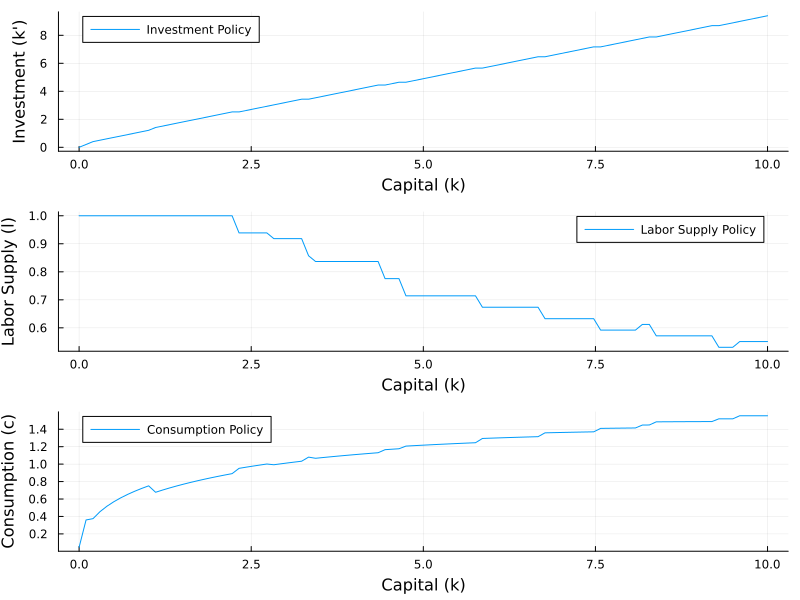

In [5]:
# Checking to see it returns the same as part 1 a
n = 100

plots_investment = []
plots_labour = []
plots_consumption = []
solution_vfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n))  
@unpack policy = solution_vfi
kgrid = LinRange(1e-4, 10, n)
l_values = LinRange(0, 1, 50)  # Defined kgrid here to use it in plotting
# Extract policy functions
ki_policy = [kgrid[policy[i][1]] for i in 1:length(policy)]  # Updated policy extraction
li_policy = [l_values[policy[i][2]] for i in 1:length(policy)] 
ci_policy = [policy[i][3] for i in 1:length(policy)]


p1 = plot(kgrid, ki_policy, xlabel="Capital (k)", ylabel="Investment (k')", label="Investment Policy")
push!(plots_investment, p1)

p2 = plot(kgrid, li_policy, xlabel="Capital (k)", ylabel="Labor Supply (l)", label="Labor Supply Policy")
push!(plots_labour, p2)

p3 = plot(kgrid, ci_policy, xlabel="Capital (k)", ylabel="Consumption (c)", label="Consumption Policy")
push!(plots_consumption, p3)

plt  = plot(plots_investment[1], plots_labour[1], plots_consumption[1], layout=(3, 1), size=(800, 600))


We show the previous graph to check whether they were similar to the what we found in part a, so this leads us to believe our implementation is working.

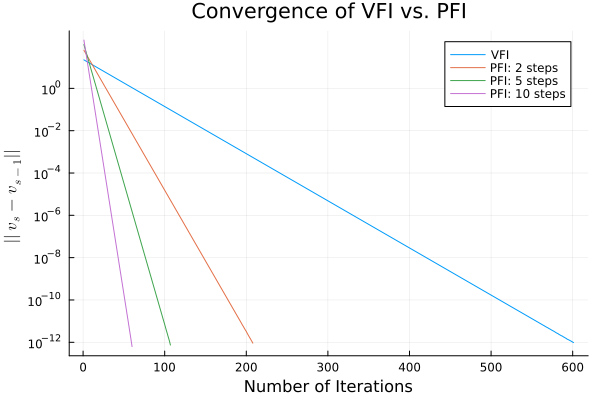

In [6]:
n = 100

solution_vfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n))
@unpack errors = solution_vfi
plt = plot(1:length(errors), errors, yscale = :log10, 
    title  = "Convergence of VFI vs. PFI",
    label  = "VFI",
    xlabel = "Number of Iterations",
    ylabel = raw"$||v_s - v_{s-1}||$",
    yticks = 10.0.^(0:-2:-12)
)

for k in (2, 5, 10)
    solution_pfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n), policy_steps = k)
    @unpack errors = solution_pfi
    plot!(1:length(errors), errors,
        label = "PFI: $k steps" 
    )
end

display(plt)

This graph appears to show that when plotting the log error, an increase in the step size increases the gradient of the lines so they get steeper indicating a faster convergence. This therefore drastically increases the runtime speed, espicially as the policy size grows. The biggest increase is from VFI to PFI with 2 steps as it decreases the number of iterations by over half which is very significant when trying to increase the speed of the code.

Part c

By using the hint and what was discussed in tutorials we reparametrise the problem as:

$$\max_{c,k',l} u(c,l) + \beta v(k') \newline s.t \newline c = \phi \cdot (F(k,l)+(1-\delta)k) \newline k' = (1-\phi) \cdot (F(k,l)+(1-\delta)k)$$ 
This makes the optimisation significanly easier as we now have box constraints where $l \in [0,1]$ and $\phi \in [0,1]$.

In [7]:
using Optim
# Parameters
p = (
    β = 0.95,    # Discount Rate
    δ = 0.05,    # Depreciation of capital
    σ = 2.0,     # Uncertainty aversion
    ν = 2.0,     # Risk aversion
    α = 1/3,     # Returns to scale
    A = 1.0,     # Productivity
    ϕ = 1.0     # Disutility from labor

)
function u(c, l, p)
    @unpack β, σ, ν, ϕ = p
    return (c^(1-σ))/(1 - σ) - ϕ * (l^(1+1/ν)/(1 + 1/ν))
end

function F(k, l)
    α=1/3
    A = 1
    return A * k^α * l^(1-α)
end
function update_bellman_cubic!(p, V, policy, kgrid, V0, spl)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n) 
    # Creating the different options for the interpolation
    if spl == "Cubic" 
        spl = CubicSplineInterpolation(kgrid, V0, extrapolation_bc=Line())
    end
    if spl == "Linear"
        spl = LinearInterpolation(kgrid, V0, extrapolation_bc=Line())
    end

    for i in 1:n
        k = kgrid[i]

        function obj_fun!(x)
            l = x[1]
            phi = x[2]
            c = phi*(A * k^α * l^(1-α) + (1-δ) * k)
            kp = (1-phi)*(A * k^α * l^(1-α) + (1-δ) * k)
            if c <= 0 || kp <= 0
                return -Inf
            end
            obj = u(c, l, p) + β * spl(kp)
            return -obj
        end
        
        # Initial guess for labor supply and phi
        x0 = [0.2, 0.5]  
        
        # Bounds for labor supply and phi
        lower = [1e-3, 1e-3]
        upper = [1.0-1e-3, 1.0-1e-3]
        
        # Optimization
        res = optimize(obj_fun!, lower, upper, x0, Fminbox())
        
        l_opt, phi_opt = Optim.minimizer(res)
        c_opt = phi_opt * (A * k^α * l_opt^(1-α) + (1-δ) * k)
        kp_opt = (1-phi_opt) * (A * k^α * l_opt^(1-α) + (1-δ) * k)
        V[i] = -obj_fun!([l_opt, phi_opt])  # Negative because we maximized negative utility
        policy[i] = (kp_opt, l_opt, c_opt)
    end
end

# Define parameters
p = (β = 0.95, δ = 0.05, σ = 2.0, ν = 2.0, α = 1/3, A = 1.0, ϕ =1.0)

# Define kgrid

kgrid = LinRange(1e-4, 10, 100)
n = length(kgrid)
V0 = V_store_for_later
V = similar(V0)
policy = Array{Tuple{Float64, Float64, Float64}, 1}(undef, n)


100-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 ⋮
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)
 (0.0, 0.0, 0.0)

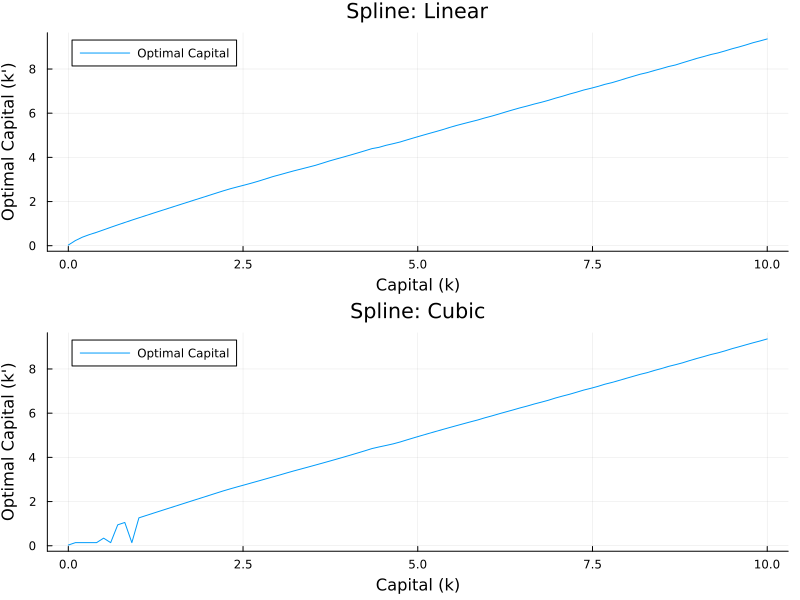

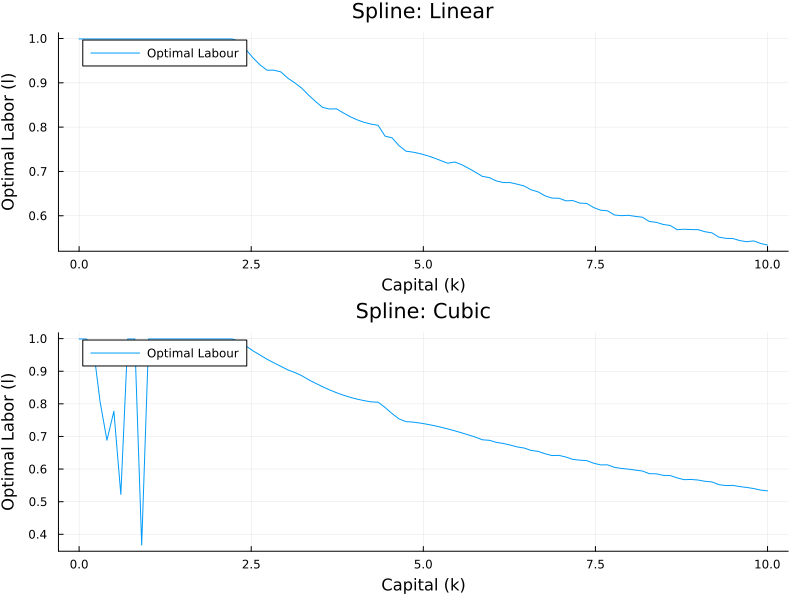

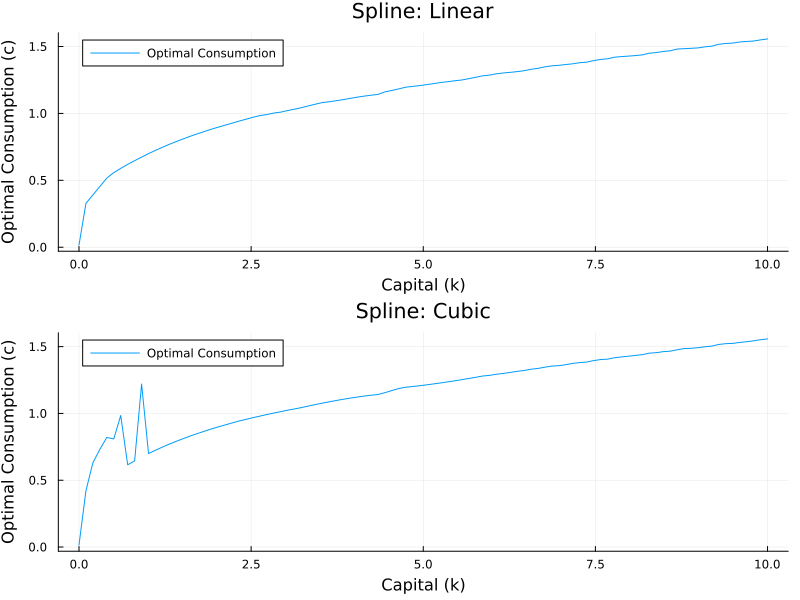

In [8]:
using Plots

plots_investment = []
plots_labour = []
plots_consumption = []

for spl in ["Linear", "Cubic"]
    update_bellman_cubic!(p, V, policy, kgrid, V0, spl)

    kp_opt = [p[1] for p in policy]
    l_opt = [p[2] for p in policy]
    c_opt = [p[3] for p in policy]

    p1 = plot(kgrid, kp_opt, xlabel="Capital (k)", ylabel="Optimal Capital (k')", label="Optimal Capital", title="Spline: $spl")
    push!(plots_investment, p1)
    
    p2 = plot(kgrid, l_opt, xlabel="Capital (k)", ylabel="Optimal Labor (l)", label="Optimal Labour", title="Spline: $spl")
    push!(plots_labour, p2)
    
    p3 = plot(kgrid, c_opt, xlabel="Capital (k)", ylabel="Optimal Consumption (c)", label="Optimal Consumption", title="Spline: $spl")
    push!(plots_consumption, p3)
end

plot_investment = plot(plots_investment..., layout=(2, 1), size=(800, 600), legend=:topleft)
plot_labour = plot(plots_labour..., layout=(2, 1), size=(800, 600), legend=:topleft)
plot_consumption = plot(plots_consumption..., layout=(2, 1), size=(800, 600), legend=:topleft)

display(plot_investment)
display(plot_labour)
display(plot_consumption)


From the previous graphs we can see that when using linear interpolation it appears to have significantly less noise than compared with the cubic interpolation. The positive from this graph is that it looks similar to the graphs we have had previously. We would suggest the curves are closer to linear curves than cubic.

These results suggest there is something incorrect with our implementation of the maximisation problem. We believe it has to do with that we could not find a repareterisation of the equation that ran. This means our calculation for k' is incorrect meaning it also affects our v(k') which is worked out by interpolation but we could not work out how to do this. Therfore we believe a discussion about how many iterations it took to converge and runtime based on our code would be misleading. However we do believe that if implemented correctly it should drastically decrease the run time as it drastically decreases the amount of iterations the code is working out.

Part d

In [9]:
using Roots
solution_pfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n), policy_steps = 2)
@unpack policy = solution_pfi
function deviation_from_steady_state(k, p, kgrid, policy)
    @unpack α, A, δ = p
    
    # Find the index of the policy function corresponding to the given capital level
    idx = searchsortedfirst(kgrid, k)
    
    # Extract the investment decision from the policy function
    ki = kgrid[policy[idx][1]]
    
    # Calculate the deviation from the steady state
    deviation = ki - k
    
    return deviation
end

function find_steady_state(p, kgrid, policy)
    # Use a root-finding algorithm to find the steady state
    k_star = find_zero(k -> deviation_from_steady_state(k, p, kgrid, policy), 4.0)
    
    # Find the corresponding labor supply using the policy function
    idx = searchsortedfirst(kgrid, k_star)
    l_star = LinRange(0, 1, 50)[policy[idx][2]]
    
    # Calculate consumption using the policy function
    c_star = policy[idx][3]
    
    return (k = k_star, l = l_star, c = c_star)
end
kgrid = LinRange(1e-6, 10, 100)
# Call the find_steady_state function with your parameters and policy functions
steady_state_result = find_steady_state(p, kgrid, policy)

# Print the steady state values
println("Steady State:")
println("Capital (k): ", steady_state_result.k)
println("Labor (l): ", steady_state_result.l)
println("Consumption (c): ", steady_state_result.c)


Steady State:
Capital (k): 4.646465181818182
Labor (l): 0.7755102040816326
Consumption (c): 1.176208815204972


The code appears to have found a steady state by finding the closest point to the initial guess where the graph is flat which is the same as the derivative being 0. Looking at the initial graph of capital from question 1 a, we can see that the point the code has found as the steady state is the first flat section on the k' graph. However, this meant that if we changed the initial guess we would converge to a different steady state, however we decided to look at the first steady state.

Part 1d

In [10]:
function simulate(p, policy, kgrid, ki0; T=15)
    @unpack α, A, δ = p
    C = zeros(T)
    L = zeros(T)
    K = zeros(T)
    Ki = zeros(Int, T)
    Kp = zeros(T)  # Define Kp array to store policy function results
    Ki[1] = ki0
    for t in 1:T
        K[t] = kgrid[Ki[t]]
        L[t] = LinRange(0, 1, 50)[policy[Ki[t]][2]]
        z = A * K[t]^α * L[t]^(1-α) + (1-δ) * K[t]
        kip = policy[Ki[t]][1]
        Kp[t] = kgrid[kip]  # Store kp value in Kp array
        C[t] = z - Kp[t]  # Use Kp[t] instead of kp
        if t < T
            Ki[t+1] = kip
        end
    end
    return (; C, K, Ki, L, Kp)
end


simulate (generic function with 1 method)

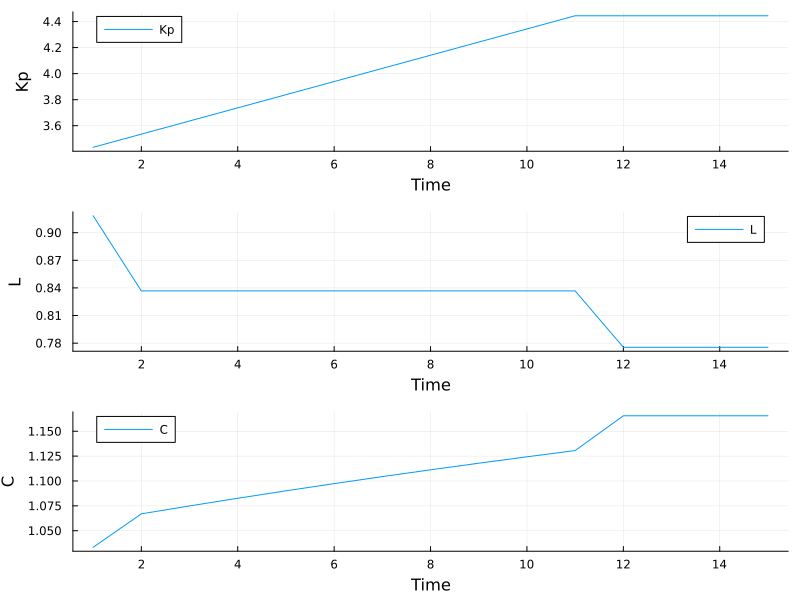

In [11]:
using Plots
# Finding the index on the kgrid closest to where 0.7*steady state k
index = argmin(abs.(kgrid .- 0.7 * steady_state_result.k))

result = simulate(p, policy, kgrid, index)

# Plot impulse response of consumption

# Create individual plots
plot1 = plot(result.Kp, xlabel="Time", ylabel="Kp", label="Kp")
plot2 = plot(result.L, xlabel="Time", ylabel="L", label="L")
plot3 = plot(result.C, xlabel="Time", ylabel="C", label="C")

# Combine plots into a single plot with layout
plt = plot(plot1, plot2, plot3, layout=(3, 1), size=(800, 600))

When we have a $k' < k^*$ we increase towards $k^*$ which corresponds to the economic intuition of what a steady state is. Because capital is gradually increasing towards the steady state value labour is decreasing and consumption is increasing. We can see that it took 12 periods to converge and then once we have reached the steady state, capital, labour and consumption is not changing implying we have reached the steady state.

Question 2
Part a

We found that the median UK income pre tax was £40,000 (https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/bulletins/householddisposableincomeandinequality/financialyearending2022/previous/v1) and the average net worth (our indicator for assets) in the Uk was £300,000 (https://cybercrew.uk/blog/average-net-worth-uk/#:~:text=Check%20Out%20the%20Top%2010%20Statistics%20We%20Picked,total%20net%20worth%20%E2%80%94about%20%C2%A34.6%20trillion.%20More%20items). Therefore, because in part b we start our distribution around the means. We will look over an income grid of 0 to 80,000 and asset grid of 0 to 600,000 but for simplicity we will divide by 1000, so the income grid is 0 to 80 and the asset grid 0 to 600. But the results should be the same as searching over the full grid if we multiply any results by a thousand. We use a grid search for the following question because even though it is the following method, we decided that because it is guaranteed to get the right answer as long as we search over a large enough grid, and we liked the certainty of this.

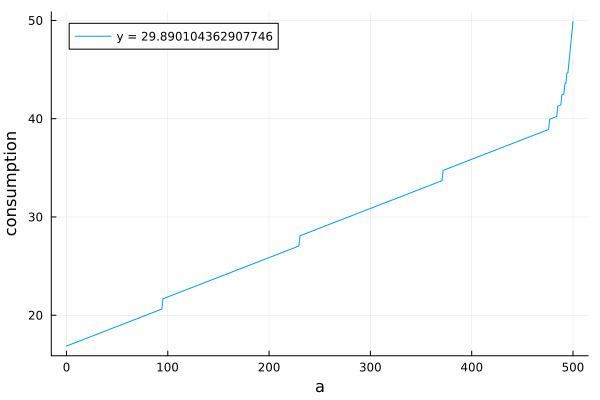

In [12]:
using QuantEcon

# Initializing parameters
beta = 0.95
r = 0.04
mu = 0.5
rho = 0.8
var = 0.1
sigma = 2

params = [beta, r, mu, rho, var, sigma]

function u(c, sigma)
    utility = similar(c)  # Create an array to store utilities
    for (i, val) in enumerate(c)
        if val <= 0
            utility[i] = -Inf
        else
            utility[i] = (val^(1-sigma))/(1-sigma)
        end
    end
    return utility
end


function update_bellman2(params, V, policy, optimal_consumption, agrid, ygrid, EV)
    beta, r, mu, rho, var, sigma = params
    for i in 1:length(agrid)
        a = agrid[i]
        for j in 1:length(ygrid)
            Y = exp(ygrid[j])

            z = (1+r)*a + Y
            c = z .- agrid  # Vectorized subtraction

            value = u(c, sigma) .+ beta * EV[:, j]

            V[i, j] = maximum(value)
            location = argmax(value)
            policy[i, j] = agrid[location]
            consumption = (1+r)*a + Y - agrid[location]
            optimal_consumption[i, j] = consumption
        end
    end
    return 
end

function solve_vfi2(params, agrid, V0, ny, tol = 1e-12, maxiter = 1000)
    V0 = copy(V0)
    beta, r, mu, rho, var, sigma = params
    V = copy(V0)
    errors = []
    iter = 0

    mc = rouwenhorst(ny, rho, var, mu)
    P = mc.p
    P = transpose(P)
    ygrid = mc.state_values

    V = zeros(length(agrid), length(ygrid))
    policy = zeros(Float64, length(agrid), length(ygrid)) # Change type to Float64
    optimal_consumption = zeros(length(agrid), length(ygrid))
    
    # Convert agrid to an array of Float64
    agrid_array = collect(agrid)
    
    while true
        iter += 1
        EV = V0 * P

        update_bellman2(params, V, policy, optimal_consumption, agrid_array, ygrid, EV)

        error = maximum(abs.(V .- V0))
        push!(errors, error)
        if error < tol || iter >= maxiter
            break
        end
        V0 .= V
    end
    
    return V, policy, optimal_consumption, iter, errors, agrid_array, ygrid
end


ny = 30
na = 500

agrid = range(1e-6, stop=500.0, length=na)  # Use range instead of LinRange
V0 = zeros(na, ny)
solution = solve_vfi2(params, agrid, V0, ny, 1e-3, 1000)

consumption = solution[3]
ygrid = solution[7]

using Plots

# Plotting the optimal consumption vs a for the highest possible starting value of y we have on our grid
plot(agrid, consumption[:,end], label = "y = $(exp(ygrid[end]))", xlabel = "a", ylabel = "consumption")


In [13]:
ny = 30
na = 500
agrid = range(1e-6, stop=500.0, length=na)  # Use range instead of LinRange
V0 = zeros(na, ny)
solution = solve_vfi2(params, agrid, V0, ny, 1e-3, 1000)

Aprime = solution[2]
consumption = solution[3]
ygrid = solution[6]
Y = [5, 10, 15, 20]

4-element Vector{Int64}:
  5
 10
 15
 20

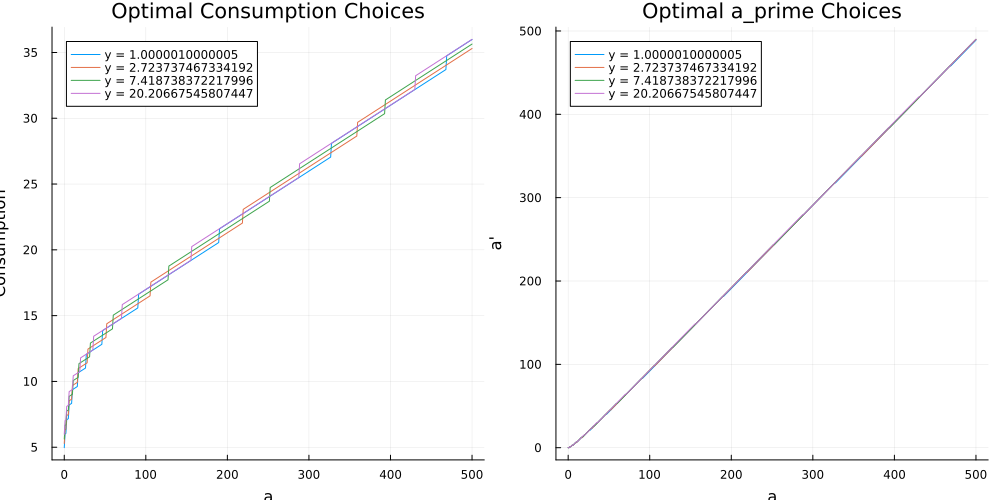

In [14]:
using Plots

# Create a plot for optimal consumption choices
plot1 = plot(size = (1000, 500), xlabel = "a", title = "Optimal Consumption Choices", ylabel = "Consumption")
for i in eachindex(Y)
    plot!(agrid, consumption[:, i], label = "y = $(exp(ygrid[i]))")
end

# Create a plot for optimal a_prime choices
plot2 = plot(size = (1000, 500), xlabel = "a", title = "Optimal a_prime Choices", ylabel = "a'")
for i in eachindex(Y)
    plot!(agrid, Aprime[:, i], label = "y = $(exp(ygrid[i]))")
end

plot(plot1, plot2, legend = true)

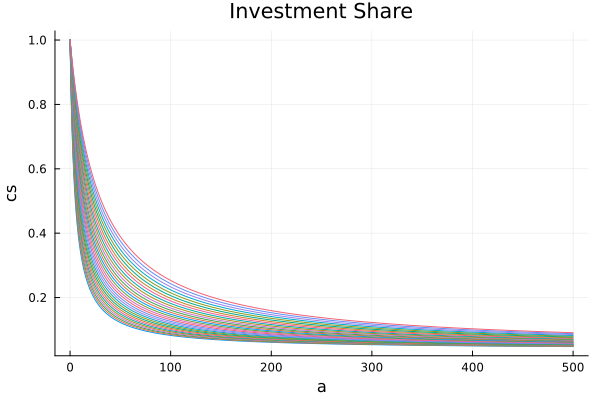

In [15]:
agrid, ygrid = solution[6], solution[7]
a′ = agrid[:]
z  = exp.(ygrid') .+ (1+r) .* agrid
c  = z .- a′

# Consumption/investment share 
cs = c ./ z
as = a′ ./ z

using Plots
plot()
display(plot!(agrid, as, xlabel="a", ylabel="as", title="Consumption Share", legend=false))
plot()
display(plot!(agrid, cs, xlabel="a", ylabel="cs", title="Investment Share", legend=false))

From the graph we can see that the investment share plus the consumption share add to 1. However there is a negative correlation between consumption share and a, and a positive correlation between investment share and a. We see that as assets (a) rise the consumption share significantly rises while the investment share significantly decreases. After assets greater than about 25 the consumption share is over 75%. What is interesting is that we see there are from everyone startng with 0 assets there are many different end points of the consumption and investment share that can be reached. Just looking at the comsumption share, the end points are between 0.75 and 0.85. Meaning that there must be differences to end up at different final positions. 

2 b

In [16]:
solution = solve_vfi2(params, agrid, V0, ny, 1e-3, 1000)
policy = solution[2]

500×30 Matrix{Float64}:
   1.0e-6     1.0e-6     1.0e-6     1.0e-6   …   11.022    12.024    13.0261
   1.0e-6     1.0e-6     1.0e-6     1.0e-6       12.024    13.0261   14.0281
   1.00201    1.00201    1.00201    1.00201      13.0261   14.0281   15.0301
   1.00201    1.00201    1.00201    1.00201      14.0281   15.0301   16.0321
   2.00401    2.00401    2.00401    2.00401      15.0301   16.0321   17.0341
   3.00601    3.00601    3.00601    3.00601  …   15.0301   17.0341   18.0361
   3.00601    3.00601    3.00601    3.00601      16.0321   18.0361   19.0381
   4.00802    4.00802    4.00802    4.00802      17.0341   19.0381   20.0401
   5.01002    5.01002    5.01002    5.01002      18.0361   20.0401   21.0421
   6.01203    6.01203    6.01203    6.01203      19.0381   21.0421   22.0441
   ⋮                                         ⋱                      
 480.962    481.964    481.964    481.964       496.994   497.996   497.996
 481.964    482.966    482.966    482.966       497.996   497

In [17]:
using Distributions

# Define the function to generate the distribution for next period's output
function log_output_distribution(y, μ, ρ, σ)
    μ_next = μ + ρ * log(y)
    return Normal(μ_next, σ)
end

# Define the function to generate a stochastic process for income
function generate_stochastic_process(μ, ρ, σ, y0, periods)
    y_values = zeros(periods)
    y_values[1] = y0
    dist = log_output_distribution(y0, μ, ρ, σ)
    for t in 2:periods
        y_values[t] = exp(rand(dist))  # Exponentiate to get actual output value
        dist = log_output_distribution(y_values[t], μ, ρ, σ)
    end
    return y_values
end

# Define parameters
μ = 0.5
ρ = 0.8
σ = 0.1
y0 = 40.0
periods = 100
num_individuals = 5
r = 0.04  # Interest rate

# Create empty arrays to store results
A_bin = []
C_bin = []
Y_bin = []

# Starting values
a0p = 250
y0 = 15
# First position on the asset grid
a_next = policy[a0p+1, y0+1]  # Assuming policy is defined somewhere

# Loop for 5 individuals
for i in 1:num_individuals
    a_next = policy[a0p, y0]  # Resetting the initial asset value for each individual
    a_bin = []
    c_bin = []
    y_bin = []
    income_process = generate_stochastic_process(μ, ρ, σ, y0, periods)
    # Loop over 100 periods
    for j in 1:periods
        y_value = Int(ceil(income_process[j]))  # Get income for this period from the stochastic process
        push!(y_bin, y_value)  # Store income
        a_previous = Int(ceil(a_next))
        a_next = policy[Int(ceil(a_next)), Int(ceil(y_value))]  # Assuming policy varies with time
        push!(a_bin, a_next)  # Store asset holdings
        consumption = (1 + r) * agrid[a_previous] + y_value - agrid[Int(ceil(a_next))]  # Calculate consumption for each period
        push!(c_bin, consumption)  # Store consumption
    end
    push!(A_bin, a_bin)
    push!(C_bin, c_bin)
    push!(Y_bin, y_bin)
end


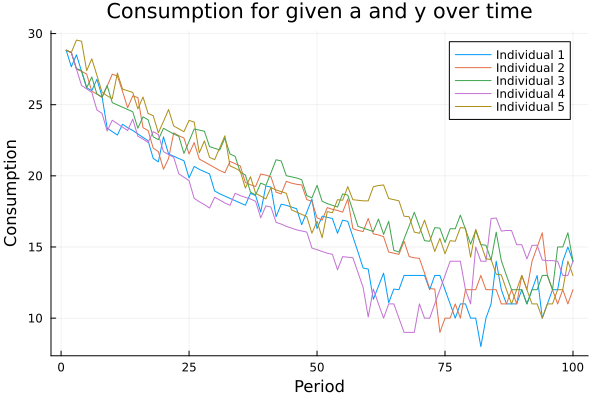

In [18]:
# Plot Consumption
plot()
for i in 1:num_individuals
    plot!(1:periods, C_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("Consumption")
title!("Consumption for given a and y over time")

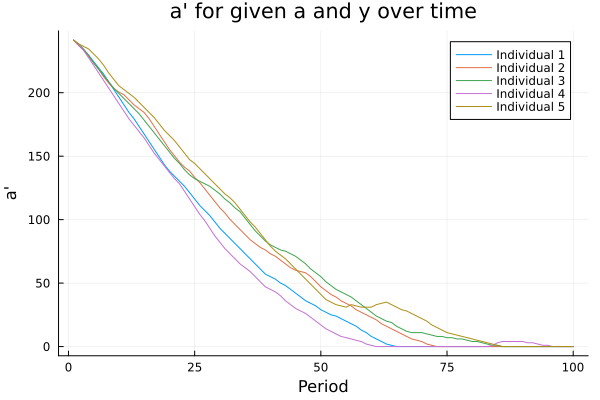

In [19]:
# Plot a'
plot()
for i in 1:num_individuals
    plot!(1:periods, A_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("a'")
title!("a' for given a and y over time")

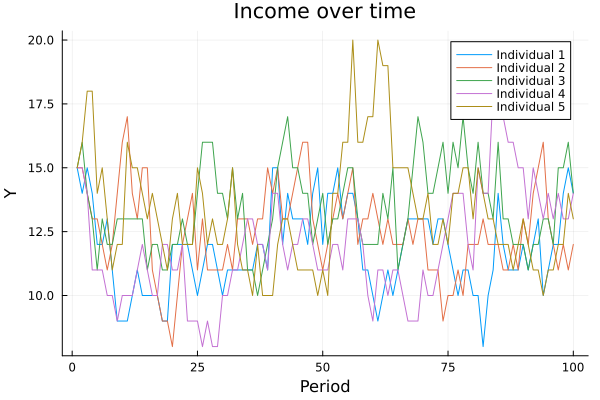

In [20]:
# Plot Y
plot()
for i in 1:num_individuals
    plot!(1:periods, Y_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("Y")
title!("Income over time")

It appears as though the graph is income is what we would expect. However, consumption is decreasing until assets have been reduced to 0 then consumption follows income. We believe this is not what we were meant to show but could not work out were we went wrong.

part c

In [21]:
dist_bin_100 = []
for i in 1:10000
    income_process = generate_stochastic_process(μ, ρ, σ, y0, 100)

    for j in 1:100
        y_rand = income_process[j]
        a_next = policy[Int(ceil(a_next)), Int(ceil(y_rand))]
        a = agrid[Int(ceil(a_next))]
        if j==100
            push!(dist_bin_100, a)
        end
    end
end

dist_bin_200 = []
for i in 1:10000
    income_process = generate_stochastic_process(μ, ρ, σ, y0, 200)

    for j in 1:200
        y_rand = income_process[j]
        a_next = policy[Int(ceil(a_next)), Int(ceil(y_rand))]
        a = agrid[Int(ceil(a_next))]
        if j==200
            push!(dist_bin_200, a)
        end
    end


end


dist_bin_300 = []
for i in 1:10000
    income_process = generate_stochastic_process(μ, ρ, σ, y0, 300)

    for j in 1:300
        y_rand = income_process[j]
        a_next = policy[Int(ceil(a_next)), Int(ceil(y_rand))]
        a = agrid[Int(ceil(a_next))]
        if j==300
            push!(dist_bin_300, a)
        end
    end


end

┌ Info: Saved animation to c:\Users\reube\OneDrive\Desktop\Econ_programming\Week_8\histogram_animation.gif
└ @ Plots C:\Users\reube\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\reube\\OneDrive\\Desktop\\Econ_programming\\Week_8\\histogram_animation.gif")
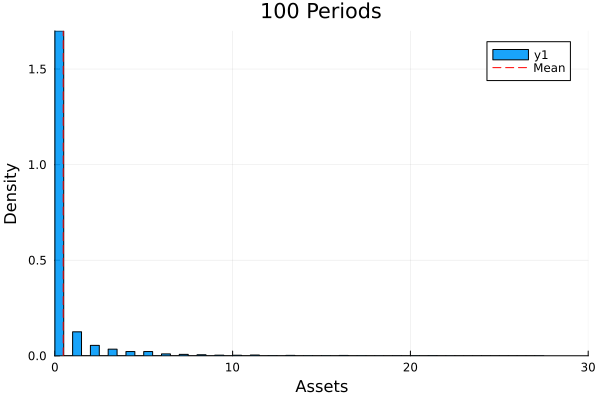

In [22]:
using Plots
gr()


# Define the histograms
plot1 = histogram(dist_bin_100, title="100 Periods", bins=50, normalize=true, fillalpha=0.9, xlabel="Assets", ylabel="Density", legend=:topright, xlimit=(0,30))
vline!(plot1, [mean(dist_bin_100)], line=:dash, color=:red, label="Mean")

plot2 = histogram(dist_bin_200, title="200 Periods", bins=50, normalize=true, fillalpha=0.9, xlabel="Assets", ylabel="Density", legend=:topright, xlimit=(0,30))
vline!(plot2, [mean(dist_bin_200)], line=:dash, color=:red, label="Mean")

plot3 = histogram(dist_bin_300, title="300 Periods", bins=50, normalize=true, fillalpha=0.9, xlabel="Assets", ylabel="Density", legend=:topright, xlimit=(0,30))
vline!(plot3, [mean(dist_bin_300)], line=:dash, color=:red, label="Mean")

# Create animation
anim = @animate for i in 1:3
    if i == 1
        plot(plot1)
    elseif i == 2
        plot(plot2)
    else
        plot(plot3)
    end
end

# Save animation as a GIF
gif(anim, "histogram_animation.gif", fps = 2)


These graphs show asset distribution in final period for 100, 200 and 300 periods. After what was discussed in the tutorial we see that we have an ergodic distribution, which means if they ever converge they are not estimating the whole distribution. However, there is a very significant left tail indicating most perople end up with no assets after 100 periods and this doesn't change as the periods increase.

Part d

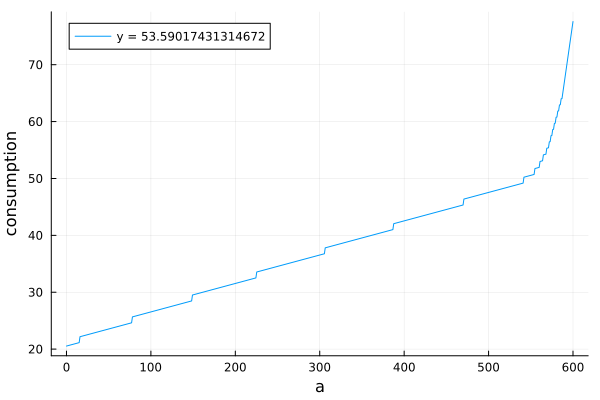

In [23]:

function update_bellman2(params, V, policy, optimal_consumption, agrid, ygrid, EV)
    tax = 0.25
    beta, r, mu, rho, var, sigma = params
    for i in 1:length(agrid)
        a = agrid[i]
        for j in 1:length(ygrid)
            Y = exp(ygrid[j])

            z = ((1+(1-tax)*r)*a + Y)
            c = z .- agrid  # Vectorized subtraction

            value = u(c, sigma) .+ beta * EV[:, j]

            V[i, j] = maximum(value)
            location = argmax(value)
            policy[i, j] = agrid[location]
            consumption = (1+r)*a + Y - agrid[location]
            optimal_consumption[i, j] = consumption
        end
    end
    return 
end

function solve_vfi2(params, agrid, V0, ny, tol = 1e-12, maxiter = 1000)
    V0 = copy(V0)
    beta, r, mu, rho, var, sigma = params
    V = copy(V0)
    errors = []
    iter = 0

    mc = rouwenhorst(ny, rho, var, mu)
    P = mc.p
    P = transpose(P)
    ygrid = mc.state_values

    V = zeros(length(agrid), length(ygrid))
    policy = zeros(Float64, length(agrid), length(ygrid)) # Change type to Float64
    optimal_consumption = zeros(length(agrid), length(ygrid))
    
    # Convert agrid to an array of Float64
    agrid_array = collect(agrid)
    
    while true
        iter += 1
        EV = V0 * P

        update_bellman2(params, V, policy, optimal_consumption, agrid_array, ygrid, EV)

        error = maximum(abs.(V .- V0))
        push!(errors, error)
        if error < tol || iter >= maxiter
            break
        end
        V0 .= V
    end
    
    return V, policy, optimal_consumption, iter, errors, agrid_array, ygrid
end


ny = 80
na = 600

agrid = range(1e-6, stop=600.0, length=na)  # Use range instead of LinRange
V0 = zeros(na, ny)
solution = solve_vfi2(params, agrid, V0, ny, 1e-3, 1000)

consumption = solution[3]
ygrid = solution[7]

using Plots

# Plotting the optimal consumption vs a for the highest possible starting value of y we have on our grid
plot(agrid, consumption[:,end], label = "y = $(exp(ygrid[end]))", xlabel = "a", ylabel = "consumption")

In [30]:
# Extracting values from the solution tuple
V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution

using Distributions

# Define the function to generate the distribution for next period's output
function log_output_distribution(y, μ, ρ, σ)
    μ_next = μ + ρ * log(y)
    return Normal(μ_next, σ)
end

# Define the function to generate a stochastic process for income
function generate_stochastic_process(μ, ρ, σ, y0, periods)
    y_values = zeros(periods)
    y_values[1] = y0
    dist = log_output_distribution(y0, μ, ρ, σ)
    for t in 2:periods
        y_values[t] = exp(rand(dist))  # Exponentiate to get actual output value
        dist = log_output_distribution(y_values[t], μ, ρ, σ)
    end
    return y_values
end

# Define parameters
μ = 0.5
ρ = 0.8
σ = 0.1
y0 = 40.0
periods = 100
num_individuals = 5
r = 0.04  # Interest rate

# Create empty arrays to store results
A_bin = []
C_bin = []
Y_bin = []

# Starting values
a0p = 250
y0 = 15
# First position on the asset grid
a_next = policy[a0p+1, y0+1]  # Assuming policy is defined somewhere

# Loop for 5 individuals
for i in 1:num_individuals
    a_next = policy[a0p, y0]  # Resetting the initial asset value for each individual
    a_bin = []
    c_bin = []
    y_bin = []
    income_process = generate_stochastic_process(μ, ρ, σ, y0, periods)
    # Loop over 100 periods
    for j in 1:periods
        y_value = Int(ceil(income_process[j]))  # Get income for this period from the stochastic process
        push!(y_bin, y_value)  # Store income
        a_previous = Int(ceil(a_next))
        a_next = policy[Int(ceil(a_next)), Int(ceil(y_value))]  # Assuming policy varies with time
        push!(a_bin, a_next)  # Store asset holdings
        consumption = (1 + r) * agrid[a_previous] + y_value - agrid[Int(ceil(a_next))]  # Calculate consumption for each period
        push!(c_bin, consumption)  # Store consumption
    end
    push!(A_bin, a_bin)
    push!(C_bin, c_bin)
    push!(Y_bin, y_bin)
end


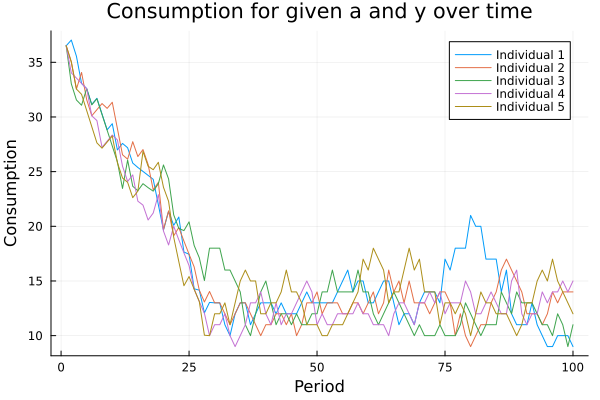

In [31]:
using Plots

# Plot Consumption
plot()
for i in 1:5
    plot!(1:100, C_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("Consumption")
title!("Consumption for given a and y over time")

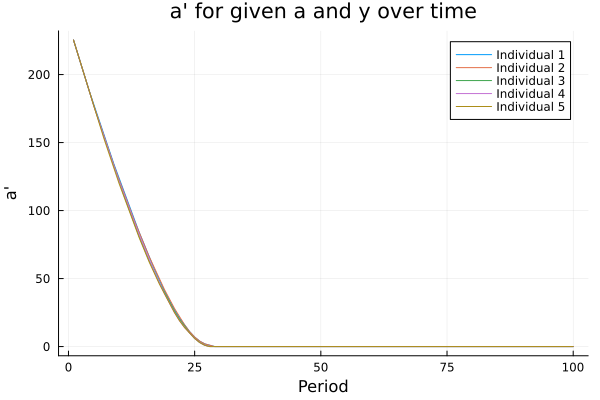

In [32]:
# Plot a'
plot()
for i in 1:5
    plot!(1:100, A_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("a'")
title!("a' for given a and y over time")


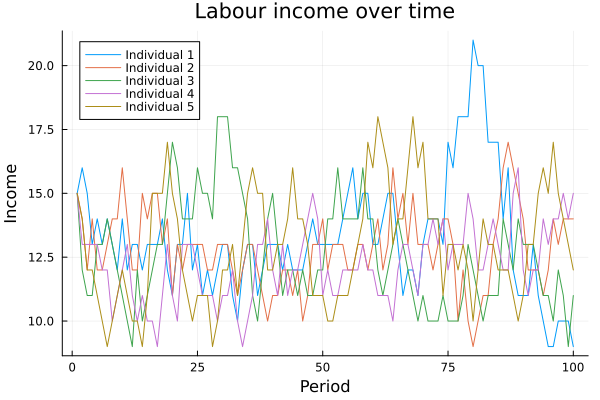

In [33]:

# Plot Income
plot()
for i in 1:5
    plot!(1:100, Y_bin[i], label="Individual $i")
end
xlabel!("Period")
ylabel!("Income")
title!("Labour income over time")

From this graph we see that with tax the individuals would rather have high consumption initially rather than it being taxed, this can also be seen by the assets being used up very quickly, then it appears as though consumption then follows a similar pattern to income. Because of the tax it appears as though there is less incentive to store assets.

In [28]:
dist_bin_100 = []
for i in 1:10000
    income_process = generate_stochastic_process(μ, ρ, σ, y0, 100)

    for j in 1:100
        y_rand = income_process[j]
        a_next = policy[Int(ceil(a_next)), Int(ceil(y_rand))]
        a = agrid[Int(ceil(a_next))]
        if j==100
            push!(dist_bin_100, a)
        end
    end
end

dist_bin_200 = []
for i in 1:10000
    income_process = generate_stochastic_process(μ, ρ, σ, y0, 200)

    for j in 1:200
        y_rand = income_process[j]
        a_next = policy[Int(ceil(a_next)), Int(ceil(y_rand))]
        a = agrid[Int(ceil(a_next))]
        if j==200
            push!(dist_bin_200, a)
        end
    end


end


dist_bin_300 = []
for i in 1:10000
    income_process = generate_stochastic_process(μ, ρ, σ, y0, 300)

    for j in 1:300
        y_rand = income_process[j]
        a_next = policy[Int(ceil(a_next)), Int(ceil(y_rand))]
        a = agrid[Int(ceil(a_next))]
        if j==300
            push!(dist_bin_300, a)
        end
    end


end

┌ Info: Saved animation to c:\Users\reube\OneDrive\Desktop\Econ_programming\Week_8\histogram_animation.gif
└ @ Plots C:\Users\reube\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\reube\\OneDrive\\Desktop\\Econ_programming\\Week_8\\histogram_animation.gif")
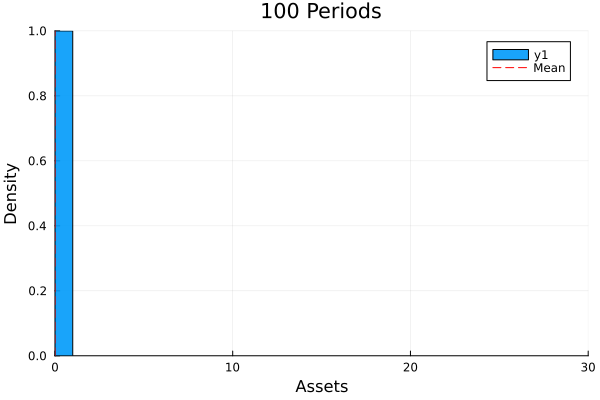

In [29]:
using Plots
gr()


# Define the histograms
plot1 = histogram(dist_bin_100, title="100 Periods", bins=50, normalize=true, fillalpha=0.9, xlabel="Assets", ylabel="Density", legend=:topright, xlimit=(0,30))
vline!(plot1, [mean(dist_bin_100)], line=:dash, color=:red, label="Mean")

plot2 = histogram(dist_bin_200, title="200 Periods", bins=50, normalize=true, fillalpha=0.9, xlabel="Assets", ylabel="Density", legend=:topright, xlimit=(0,30))
vline!(plot2, [mean(dist_bin_200)], line=:dash, color=:red, label="Mean")

plot3 = histogram(dist_bin_300, title="300 Periods", bins=50, normalize=true, fillalpha=0.9, xlabel="Assets", ylabel="Density", legend=:topright, xlimit=(0,30))
vline!(plot3, [mean(dist_bin_300)], line=:dash, color=:red, label="Mean")

# Create animation
anim = @animate for i in 1:3
    if i == 1
        plot(plot1)
    elseif i == 2
        plot(plot2)
    else
        plot(plot3)
    end
end

# Save animation as a GIF
gif(anim, "histogram_animation.gif", fps = 2)


It would appear the tax has completely disincetivised storing assets for future periods. As a higher tax disincentivizes investment because the household does not perceive the full return.

Part e

We did not have enough time to attempt this question but if we did we would loop over different tax rates until it corresponds to the amount that we wanted.